딥러닝 기초 스터디 / 박찬영

# 📌 7.5. LSTM

☑️ **7.5.2. LSTM 셀 구현**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("drive/MyDrive/2025-1 프로메테우스 스터디")

download_root = 'chap07/MNIST_DATASET'

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))  # 데이터 정규화 (평균 0.5, 표준편차 1.0)
])

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

Mounted at /content/drive


In [ ]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # 입력층 특성 수, 입력층-은닉층 가중치, 바이어스
        # 가중치 -> 망각, 입력, 셀, 출력 게이트 변수에 각각 저장 (4X 4)
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        # 은닉층 특성 수, 은닉층-은닉층 가중치, 바이어스
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):  # 파라미터 초기화
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)  # 난수 생성

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()  # 텐서 차원 줄이
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)  # 몇 개로 어떤 차원을 기준으로 쪼갤지

        ingate = F.sigmoid(ingate)  # 입력 게이트 -> 시그모이드 활성화 함수
        forgetgate = F.sigmoid(forgetgate)  # 망각 게이트 -> 시그모이드 활성화 함수
        cellgate = F.tanh(cellgate)  # 셀 게이트 -> 탄젠트 활성화 함수 적용
        outgate = F.sigmoid(outgate)  # 출력 게이트 -> 시그모이드 활성화 함수 적용

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return(hy, cy)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim  # 은닉층 뉴런 개수
        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)  # 특성 개수, 은닉층 뉴런 개수, 은닉층 계층 개수
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available():
            # (은닉층 계층 개수, 배치 크기, 은닉층 뉴런 개수) 형태 은닉 상태 -> 0으로 초기화
            h0 = autograd.Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = autograd.Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available():
            c0 = autograd.Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = autograd.Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        outs = []
        cn = c0[0,:,:]  # 셀 상태
        hn = h0[0,:,:]  # 은닉 상태

        for seq in range(x.size(1)):  # LSTM 셀 계층 반복하여 쌓아 올리기
            hn, cn = self.lstm(x[:,seq,:], (hn,cn))  # LSTMCell에 적용한 결과
            outs.append(hn)

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  # 훈련 데이터셋
        if torch.cuda.is_available():
            images = autograd.Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = autograd.Variable(labels.cuda())
        else:
            images = autograd.Variable(images.view(-1, seq_dim, input_dim))
            labels = autograd.Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # 오차 계산

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()  # 파라미터 업데이트
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:  # 정확도(accuracy) 계산
            correct = 0
            total = 0
            for images, labels in valid_loader:  # 검증 데이터셋

                if torch.cuda.is_available():
                    images = autograd.Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = autograd.Variable(images.view(-1, seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)  # 예측 결과

                total += labels.size(0)  # 총 레이블 수
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2508296966552734. Accuracy: 20.959999084472656
Iteration: 1000. Loss: 0.7207237482070923. Accuracy: 74.55000305175781
Iteration: 1500. Loss: 0.2766208350658417. Accuracy: 89.88999938964844
Iteration: 2000. Loss: 0.35248443484306335. Accuracy: 92.1500015258789
Iteration: 2500. Loss: 0.08268168568611145. Accuracy: 95.88999938964844
Iteration: 3000. Loss: 0.08079920709133148. Accuracy: 96.20999908447266
Iteration: 3500. Loss: 0.15787658095359802. Accuracy: 96.77999877929688
Iteration: 4000. Loss: 0.07772055268287659. Accuracy: 97.12000274658203
Iteration: 4500. Loss: 0.028515251353383064. Accuracy: 97.37000274658203
Iteration: 5000. Loss: 0.03437937796115875. Accuracy: 97.26000213623047
Iteration: 5500. Loss: 0.12129831314086914. Accuracy: 97.47000122070312
Iteration: 6000. Loss: 0.06415150314569473. Accuracy: 97.80000305175781


In [ ]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = autograd.Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = autograd.Variable(images.view(-1, seq_dim, input_dim)).to(device)

        logit = model(images)
        loss = F.cross_entropy(logit.cuda(), labels.cuda(), reduction="sum")  # 모든 오차 더하기
        _, predicted = torch.max(logit.data, 1)  # 최댓값의 인덱스 반환
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted.to(device) == labels.to(device)).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

test_loss, test_acc = evaluate(model, test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.08 | Test Accuracy:  0.98


☑️ **7.5.3. LSTM 계층 구현**

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)  # date 칼럼을 인덱스로 사용

data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]  # 마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y = data.iloc[:, 5:6]  # 마지막 'Volume'을 레이블로 사용
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [ ]:
ms = MinMaxScaler()  # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler()  # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]  # 훈련 데이터셋
X_test = X_ss[200:, :]  # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [ ]:
# Variable로 감싸진 텐서는 .backward()가 호출될 때 자동으로 기울기 계산
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# LSTM 네트워크의 입력 형태와 맞추기
X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers  # LSTM 계층의 개수
        self.input_size = input_size  # 입력 크기 (칼럼 개수)
        self.hidden_size = hidden_size  # 은닉층 뉴런 개수
        self.seq_length = seq_length  # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)  # 완전연결층
        self.fc = nn.Linear(128, num_classes)  # 출력층
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # 은닉 상태  초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # 셀 상태 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정(1차원)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5  # 입력 데이터 칼럼(feature) 개수
hidden_size = 2  # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1  # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)  # 오차 계산
    loss.backward()  # 기울기 계산

    optimizer.step()  # 오차 업데이트
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.28979
Epoch: 100, loss: 0.10804
Epoch: 200, loss: 0.05273
Epoch: 300, loss: 0.04240
Epoch: 400, loss: 0.04055
Epoch: 500, loss: 0.03940
Epoch: 600, loss: 0.03804
Epoch: 700, loss: 0.03614
Epoch: 800, loss: 0.03430
Epoch: 900, loss: 0.03295


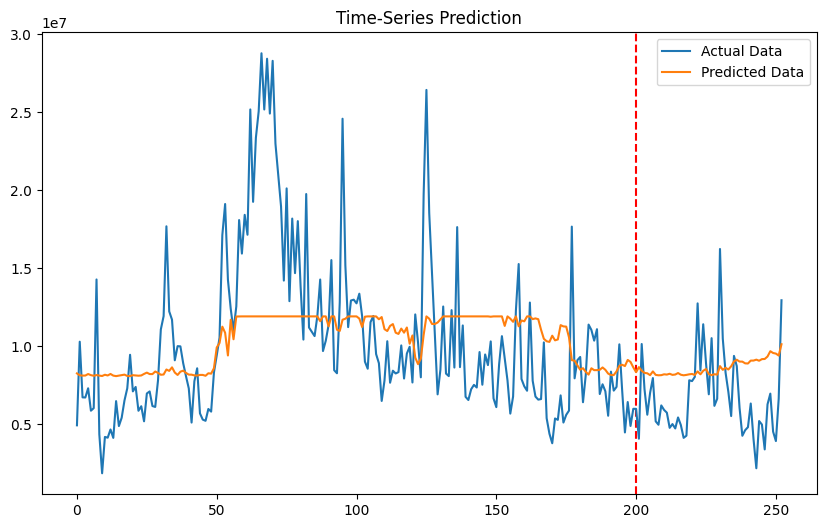

In [ ]:
df_x_ss = ss.transform(data.iloc[:, :-1])  # 데이터 정규화(분포 조정)
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)  # 전처리(정규화) 해제
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')  # 수직선 표현

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()


\

---


\

# 📌 7.6. 게이트 순환 신경망(GRU)

☑️ **7.6.2 GRU 셀 구현**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# import os
# os.chdir("drive/MyDrive/2025-1 프로메테우스 스터디")

download_root = 'chap07/MNIST_DATASET'

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))  # 데이터 정규화 (평균 0.5, 표준편차 1.0)
])

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True)

In [ ]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)  # 3개의 게이트 (망각, 입력, 탄젠트 활성화 부분)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):  # 파라미터 초기화
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        x = x.view(-1, x.size(1))

        gate_x = self.x2h(x)  # 개별적인 상태 유지 (LSTM 셀 gates는 x2h+h2h)
        gate_h = self.h2h(hidden)
        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()

        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)

        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))  # 탄젠트 활성화 함수가 적용된 게이트

        hy = newgate + inputgate * (hidden - newgate)
        return hy

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        outs = []
        hn = h0[0,:,:]  # 셀은 사용되지 않음

        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:,seq,:], hn)
            outs.append(hn)
            out = outs[-1].squeeze()
            out = self.fc(out)
            return out

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1, seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.298945665359497. Accuracy: 11.350000381469727
Iteration: 1000. Loss: 2.305758476257324. Accuracy: 11.350000381469727
Iteration: 1500. Loss: 2.3120429515838623. Accuracy: 11.350000381469727
Iteration: 2000. Loss: 2.296295166015625. Accuracy: 11.350000381469727
Iteration: 2500. Loss: 2.3116133213043213. Accuracy: 11.350000381469727
Iteration: 3000. Loss: 2.3033134937286377. Accuracy: 11.350000381469727
Iteration: 3500. Loss: 2.303978204727173. Accuracy: 11.350000381469727
Iteration: 4000. Loss: 2.3015761375427246. Accuracy: 11.350000381469727
Iteration: 4500. Loss: 2.302131175994873. Accuracy: 11.350000381469727
Iteration: 5000. Loss: 2.3142497539520264. Accuracy: 11.350000381469727
Iteration: 5500. Loss: 2.3210666179656982. Accuracy: 11.350000381469727
Iteration: 6000. Loss: 2.304821252822876. Accuracy: 11.350000381469727


In [ ]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim)).to(device)

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels.to(device), reduction="sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted.to(device) == labels.to(device)).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  2.30 | Test Accuracy:  0.11


☑️ **7.6.3. GRU 계층 구현**

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [ ]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [ ]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 은닉 상태에 대해 0으로 초기화
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1  # GRU 계층 개수

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.46538
Epoch: 100, loss: 0.19973
Epoch: 200, loss: 0.08000
Epoch: 300, loss: 0.03894
Epoch: 400, loss: 0.02789
Epoch: 500, loss: 0.02473
Epoch: 600, loss: 0.02327
Epoch: 700, loss: 0.02234
Epoch: 800, loss: 0.02169
Epoch: 900, loss: 0.02123


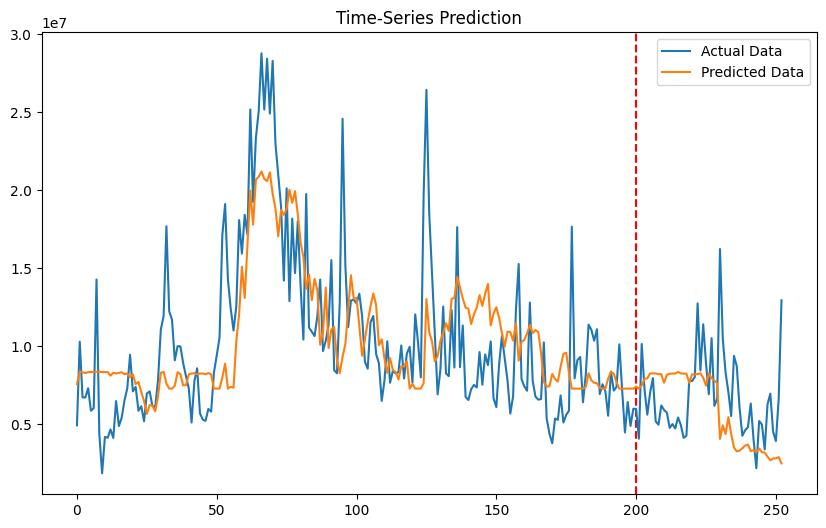

In [ ]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

\

---

\

# 📌 7.7. 양방향 RNN

**☑️ 7.7.2. 양방향 LSTM 구현**

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('chap07/data/SBUX.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]
y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [ ]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        # bidirectional = True 옵션 지정
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 한 번 학습하는 데 두 개의 계층 필요
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # 마지막 시간(TimeStep 마지막 단계)의 은닉 상태
        out = self.relu(out)
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03174
Epoch: 100, loss: 0.02839
Epoch: 200, loss: 0.02573
Epoch: 300, loss: 0.02374
Epoch: 400, loss: 0.02232
Epoch: 500, loss: 0.02133
Epoch: 600, loss: 0.02062
Epoch: 700, loss: 0.02010
Epoch: 800, loss: 0.01969
Epoch: 900, loss: 0.01935


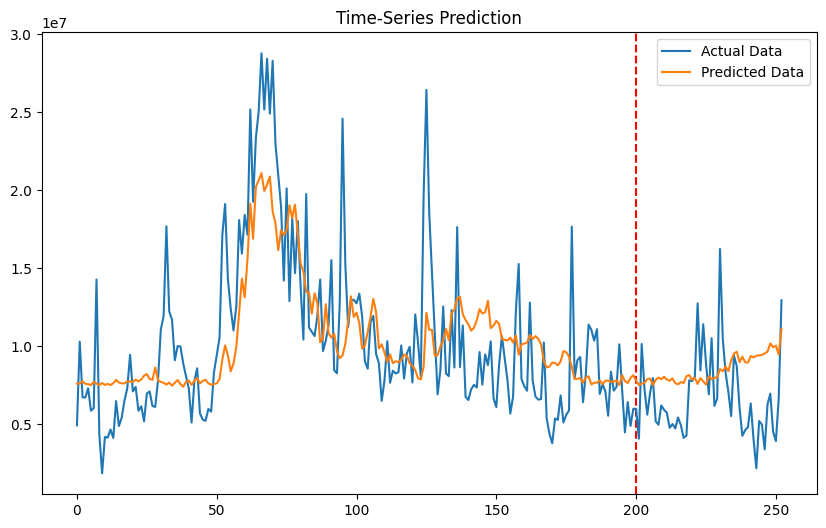

In [ ]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

\

---

\

# 📌 9.1. 자연어 처리란

**☑️ 9.1.1. 자연어 처리 용어 및 과정**

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')
text = nltk.word_tokenize("Is it possible distinguishing cats and dogs")
print(text)

['Is', 'it', 'possible', 'distinguishing', 'cats', 'and', 'dogs']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.pos_tag(text)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


[('Is', 'VBZ'),
 ('it', 'PRP'),
 ('possible', 'JJ'),
 ('distinguishing', 'VBG'),
 ('cats', 'NNS'),
 ('and', 'CC'),
 ('dogs', 'NNS')]

**☑️ 9.1.2. 자연어 처리를 위한 라이브러리**

In [ ]:
string1 = "my favorite subject is math"
string2 = "my favorite subject is math, english, economic and computer science"
(nltk.word_tokenize(string1),
 nltk.word_tokenize(string2))

(['my', 'favorite', 'subject', 'is', 'math'],
 ['my',
  'favorite',
  'subject',
  'is',
  'math',
  ',',
  'english',
  ',',
  'economic',
  'and',
  'computer',
  'science'])

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 27.0 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Komoran
komoran = Komoran()
print(komoran.morphs('딥러닝이 쉽나요? 어렵나요?'))

['딥러닝이', '쉽', '나요', '?', '어렵', '나요', '?']


In [ ]:
print(komoran.pos('소파 위에 있는 것이 고양이인가요? 강아지인가요?'))

[('소파', 'NNP'), ('위', 'NNG'), ('에', 'JKB'), ('있', 'VV'), ('는', 'ETM'), ('것', 'NNB'), ('이', 'JKS'), ('고양이', 'NNG'), ('이', 'VCP'), ('ㄴ가요', 'EF'), ('?', 'SF'), ('강아지', 'NNG'), ('이', 'VCP'), ('ㄴ가요', 'EF'), ('?', 'SF')]


**☑️ 9.2.1. 결측치 확인**

In [ ]:
import pandas as pd
df = pd.read_csv('chap09/data/class2.csv')
print(df.isnull().sum())
print(df.isnull().sum() / len(df))

Unnamed: 0    0
id            0
tissue        0
class         0
class2        0
x             2
y             2
r             2
dtype: int64
Unnamed: 0    0.000000
id            0.000000
tissue        0.000000
class         0.000000
class2        0.000000
x             0.333333
y             0.333333
r             0.333333
dtype: float64


In [ ]:
df = df.dropna(how='all')  # 모든 행이 NaN일 때만 삭제
print(df)

   Unnamed: 0      id tissue class class2      x      y      r
0           0  mdb000      C  CIRC      N  535.0  475.0  192.0
1           1  mdb001      A  CIRA      N  433.0  268.0   58.0
2           2  mdb002      A  CIRA      I    NaN    NaN    NaN
3           3  mdb003      C  CIRC      B    NaN    NaN    NaN
4           4  mdb004      F  CIRF      I  488.0  145.0   29.0
5           5  mdb005      F  CIRF      B  544.0  178.0   26.0


In [ ]:
df1 = df.dropna()  # 데이터에 하나라도 NaN 값이 있으면 행을 삭제
print(df1)

   Unnamed: 0      id tissue class class2      x      y      r
0           0  mdb000      C  CIRC      N  535.0  475.0  192.0
1           1  mdb001      A  CIRA      N  433.0  268.0   58.0
4           4  mdb004      F  CIRF      I  488.0  145.0   29.0
5           5  mdb005      F  CIRF      B  544.0  178.0   26.0


In [ ]:
df2 = df.fillna(0)
print(df2)

   Unnamed: 0      id tissue class class2      x      y      r
0           0  mdb000      C  CIRC      N  535.0  475.0  192.0
1           1  mdb001      A  CIRA      N  433.0  268.0   58.0
2           2  mdb002      A  CIRA      I    0.0    0.0    0.0
3           3  mdb003      C  CIRC      B    0.0    0.0    0.0
4           4  mdb004      F  CIRF      I  488.0  145.0   29.0
5           5  mdb005      F  CIRF      B  544.0  178.0   26.0


In [ ]:
df['x'].fillna(df['x'].mean(), inplace=True)
print(df)

   Unnamed: 0      id tissue class class2      x      y      r
0           0  mdb000      C  CIRC      N  535.0  475.0  192.0
1           1  mdb001      A  CIRA      N  433.0  268.0   58.0
2           2  mdb002      A  CIRA      I  500.0    NaN    NaN
3           3  mdb003      C  CIRC      B  500.0    NaN    NaN
4           4  mdb004      F  CIRF      I  488.0  145.0   29.0
5           5  mdb005      F  CIRF      B  544.0  178.0   26.0


<ipython-input-8-ac0ede53f64c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['x'].fillna(df['x'].mean(), inplace=True)


**☑️ 9.2.2. 토큰화**

In [ ]:
from nltk import sent_tokenize
text_sample = 'Natural Language Processing, or NLP, is the process of extracting the meaning, or intent, behind human language. In the field of Conversational artificial intelligence (AI), NLP allows machines and applications to understand the intent of human language inputs, and then generate appropriate responses, resulting in a natural conversation flow.'
tokenized_sentences = sent_tokenize(text_sample)
print(tokenized_sentences)

['Natural Language Processing, or NLP, is the process of extracting the meaning, or intent, behind human language.', 'In the field of Conversational artificial intelligence (AI), NLP allows machines and applications to understand the intent of human language inputs, and then generate appropriate responses, resulting in a natural conversation flow.']


In [ ]:
from nltk import word_tokenize
sentence = "This book is for deep learning learners"
words = word_tokenize(sentence)
print(words)

['This', 'book', 'is', 'for', 'deep', 'learning', 'learners']


In [ ]:
from nltk.tokenize import WordPunctTokenizer
sentence = "it's nothing that you don't already know except most people aren't aware of how their inner world works."
words = WordPunctTokenizer().tokenize(sentence)
print(words)

['it', "'", 's', 'nothing', 'that', 'you', 'don', "'", 't', 'already', 'know', 'except', 'most', 'people', 'aren', "'", 't', 'aware', 'of', 'how', 'their', 'inner', 'world', 'works', '.']


In [ ]:
import csv
from konlpy.tag import Okt

f = open(r'chap09/data/ratings_train.txt', 'r', encoding='utf-8')
rdr = csv.reader(f, delimiter='\t')
rdw = list(rdr)
f.close()

In [ ]:
twitter = Okt()

result = []
for line in rdw:
    malist = twitter.pos(line[1], norm=True, stem=True)  # 형태소 분석
    r = []
    for word in malist:
        if not word[1] in ["Josa","Eomi","Punctuation"]:  # 조사, 어미, 문장 부호는 제외하고 처리
            r.append(word[0])
    rl = (" ".join(r)).strip()  # 형태소 사이에 공백을 넣고, 양쪽 공백은 삭제
    result.append(rl)
    print(rl)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
정치 현실 적 모습 담다 영화 열정 채우다 스티븐 냉소 적 정치 겪다 후 변하다 모습 소름끼치다 담다 진짜 서스펜스 스릴러 뛰어나다 배우 들 연기 보다 재미 있다 남자 여자 관계 조심하다 하다 법 정치 이면
인사 이드 읏 보고 생각나다 찾아오다 ㅋㅋㅋ 어리다 때 보다 그때 느끼다 감동 아직도 생생하다 로봇 들 감정 이렇게 표현 해내다 있다
90년 대 SF 혁명 가다 준 추억 명작 정말 재미있다 즐기다 보다 90년 대 향수 느끼다
쥬드 멋지다 미소 반하다 것 같다 표정 연기 디테일 살다 카메론 너무 예쁘다
버리다
지루하다 느슨하다
말 필요없다 쓰레기 정말 정말 기대하다 더욱 실망 감 크다
차다 이래저래 이해 하다 난해하다 영화
드 팔마 이름 값 못 하다 망작 1 점도 아깝다
제이슨 쌍벽 이루다 살인마 작 강하다
이렇다 걸 만들다 건 바보 들
보아 누나 ㅈㄴ 미안하다 솔직하다 말 하다 노잼 스텝업 따르다 하다 똑바로 따르다 하등 갑자기 텝덴스 난타 웨 나오다 애국심 난타 홍보 하다 그렇다 같다 마음 갸륵한데 재미 모르갯슴 글 설정 상 일본인 이드 ㅡㅡ
앞뒤 분간 못 원 초적 본능 집착 하다 솔직하다 성인
어리다 여자애 들 좋아하다 법 유치하다 진부하다 스토리 평점 왜 이렇게 높다 모르다 영화 자체 별로 이다 앤 해서웨이 예쁘다 나오다 매다 무어 Stupid cupid 가다 인상 깊다 4 점
뭔가 아련하다 감성 충분하다 자극시키다 주다 같다
속 았 다 리뷰 믿다 내 바보 이다 CG 어디서 영상 짤 붙이다 한
1 인 2 역 출연료 두 배 받다
다큐 기대하다 아니다
당시 인기 있다 영화 기다 하지만 왜 이렇게 점수 높다
GOOD GOOD 111
뇌 잠시 끄다 보다 재미있다 있다 영화
정말 너무 재밌다 시청률 항상 안타깝다 뿐 ㅠ
powerful
전형 적 발암 영화 제대로 답답하다 경찰 대응 주인공 태도 보여주다 범인 뻔하다 스토리 뻔하다 아빠 설정 없다 되다 스릴 있다 답답하다 다르다 개다
그냥 그렇다
별

In [ ]:
with open("chap09/data/NaverMovie.nlp", 'w', encoding='utf-8') as fp:
    fp.write("\n".join(result))

In [ ]:
import sys
import numpy
import gensim

print("Python version:", sys.version)
print("NumPy version:", numpy.__version__)
print("Gensim version:", gensim.__version__)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
NumPy version: 1.24.3
Gensim version: 4.3.3


In [ ]:
!pip install --upgrade gensim
from gensim.models import word2vec
mData = word2vec.LineSentence("chap09/data/NaverMovie.nlp")
mModel = word2vec.Word2Vec(mData, vector_size=200, window=10, hs=1, min_count=2, sg=1)
mModel.save("NaverMovie.model")

**☑️ 9.2.3. 불용어 제거**

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

sample_text = "One of the first things that we ask ourselves is what are the pros and cons of any task we perform."
text_tokens = word_tokenize(sample_text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]

print("불용어 제거 미적용:", text_tokens, '\n')
print("불용어 제거 적용:", tokens_without_sw)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


불용어 제거 미적용: ['One', 'of', 'the', 'first', 'things', 'that', 'we', 'ask', 'ourselves', 'is', 'what', 'are', 'the', 'pros', 'and', 'cons', 'of', 'any', 'task', 'we', 'perform', '.'] 

불용어 제거 적용: ['One', 'first', 'things', 'ask', 'pros', 'cons', 'task', 'perform', '.']


**☑️ 9.2.4. 어간 추출**

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

print(stemmer.stem('obesses'), stemmer.stem('obssesed'))
print(stemmer.stem('standardizes'), stemmer.stem('standardization'))
print(stemmer.stem('national'), stemmer.stem('nation'))
print(stemmer.stem('absentness'), stemmer.stem('absently'))
print(stemmer.stem('tribalical'), stemmer.stem('tribalicalized'))  # 사전에 없는 단어

obess obsses
standard standard
nation nation
absent absent
tribal tribalic


In [ ]:
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

print(stemmer.stem('obsesses'), stemmer.stem('obsessed'))
print(stemmer.stem('standardizes'), stemmer.stem('standardization'))
print(stemmer.stem('national'), stemmer.stem('nation'))
print(stemmer.stem('absentness'), stemmer.stem('absently'))
print(stemmer.stem('tribalical'), stemmer.stem('tribalicalized'))  # 사전에 없는 단어

obsess obsess
standard standard
nat nat
abs abs
trib trib


In [ ]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

print(stemmer.stem('obsesses'), stemmer.stem('obsessed'))
print(lemma.lemmatize('standardizes'), lemma.lemmatize('standardization'))
print(lemma.lemmatize('national'), lemma.lemmatize('nation'))
print(lemma.lemmatize('absentness'), lemma.lemmatize('absently'))
print(lemma.lemmatize('tribalical'), lemma.lemmatize('tribalicalized'))

[nltk_data] Downloading package wordnet to /root/nltk_data...


obsess obsess
standardizes standardization
national nation
absentness absently
tribalical tribalicalized


In [ ]:
print(lemma.lemmatize('obsesses','v'), lemma.lemmatize('obsessed','a'))
print(lemma.lemmatize('standardizes','v'), lemma.lemmatize('standardization','n'))
print(lemma.lemmatize('national','a'), lemma.lemmatize('nation','n'))
print(lemma.lemmatize('absentness','n'), lemma.lemmatize('absently','r'))
print(lemma.lemmatize('tribalical','a'), lemma.lemmatize('tribalicalized','v'))

obsess obsessed
standardize standardization
national nation
absentness absently
tribalical tribalicalized


**☑️ 9.2.5. 정규화**

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split  # 데이터셋을 훈련과 테스트 용도로 분리
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # 정규화

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df = pd.read_csv('chap09/data/diabetes.csv')
X = df[df.columns[:-1]]
y = df['Outcome']

X = X.values
y = torch.tensor(y.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
ms = MinMaxScaler()
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = ms.fit_transform(y_train)
y_test = ms.fit_transform(y_test)

In [ ]:
class customdataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len

In [ ]:
train_data = customdataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = customdataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        self.layer_1 = nn.Linear(8, 64, bias=True)  # 입력 크기 8
        self.layer_2 = nn.Linear(64, 64, bias=True)
        self.layer_out = nn.Linear(64, 1, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [ ]:
epochs = 1000+1
print_epoch = 100
LEARNING_RATE = 1e-2

model = binaryClassification()
model.to(device)
print(model)
BCE = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=8, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
for epoch in range(epochs):
    iteration_loss = 0.
    iteration_accuracy = 0.

    model.train()
    for i, data in enumerate(train_loader):
        X, y = data
        y_pred = model(X.to(device).float())
        loss = BCE(y_pred.to(device), y.reshape(-1,1).float().to(device))  # 손실 함수 적용

        iteration_loss += loss  # 오차 누적
        iteration_accuracy += accuracy(y_pred, y.to(device))  # 정확도 누적
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch % print_epoch == 0):
        print('Train: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, iteration_loss/(i+1), iteration_accuracy/(i+1)))

    iteration_loss = 0.
    iteration_accuracy = 0.
    model.eval()  # 모델 검증
    for i, data in enumerate(test_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = BCE(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss
        iteration_accuracy += accuracy(y_pred, y.to(device))
    if(epoch % print_epoch == 0):
        print('Test: epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch,
              iteration_loss/(i+1), iteration_accuracy/(i+1)))

Train: epoch: 0 - loss: 0.56933; acc: 70.889
Test: epoch: 0 - loss: 0.60410; acc: 70.750
Train: epoch: 100 - loss: 0.40442; acc: 79.778
Test: epoch: 100 - loss: 0.45575; acc: 79.250
Train: epoch: 200 - loss: 0.55570; acc: 77.667
Test: epoch: 200 - loss: 0.46210; acc: 80.000
Train: epoch: 300 - loss: 0.51056; acc: 77.889
Test: epoch: 300 - loss: 0.47444; acc: 77.250
Train: epoch: 400 - loss: 0.32203; acc: 85.889
Test: epoch: 400 - loss: 0.46778; acc: 77.250
Train: epoch: 500 - loss: 0.42110; acc: 82.778
Test: epoch: 500 - loss: 0.45272; acc: 77.500
Train: epoch: 600 - loss: 0.43753; acc: 80.111
Test: epoch: 600 - loss: 0.56646; acc: 72.250
Train: epoch: 700 - loss: 0.57585; acc: 76.000
Test: epoch: 700 - loss: 0.46746; acc: 75.250
Train: epoch: 800 - loss: 0.35592; acc: 83.444
Test: epoch: 800 - loss: 0.47623; acc: 79.500
Train: epoch: 900 - loss: 0.42923; acc: 81.778
Test: epoch: 900 - loss: 0.47391; acc: 79.000
Train: epoch: 1000 - loss: 0.50194; acc: 77.333
Test: epoch: 1000 - loss: 